/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/2
1563/1563 [==============================] - loss: 0.0 - accuracy: 0.0 - val_loss: 2.3060595989227295 - val_accuracy: 0.10000000149011612
Epoch 2/2
157/157 [==============================] - 6s 35ms/step - loss: 2.3061 - accuracy: 0.1000


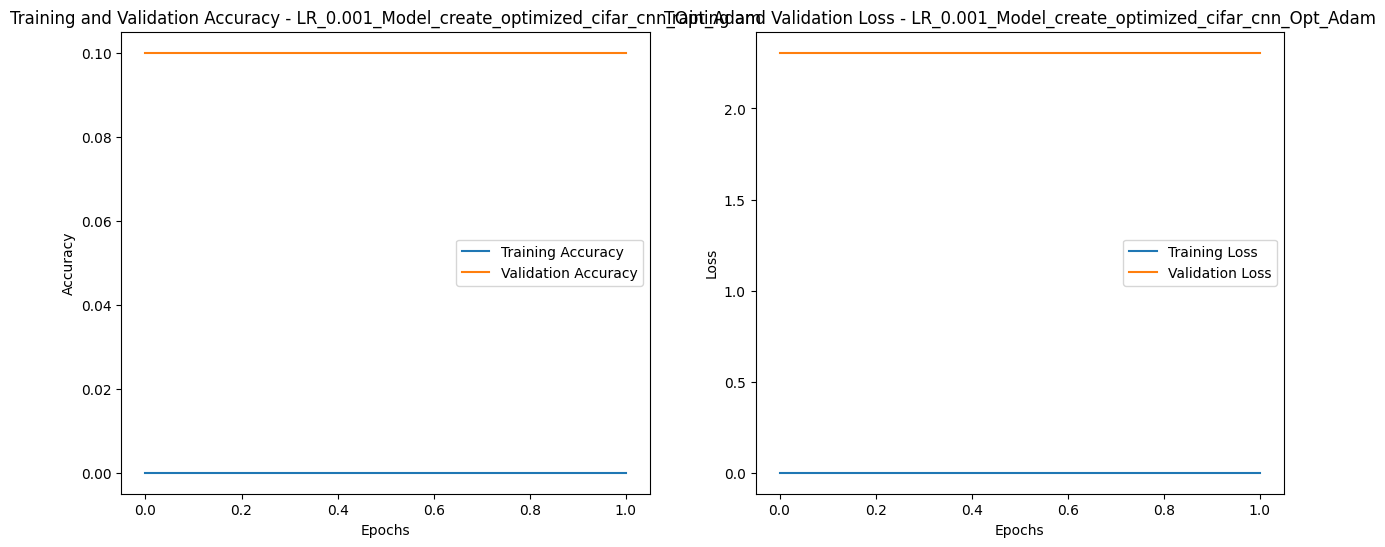

Epoch 1/2
1563/1563 [==============================] - loss: 0.0 - accuracy: 0.0 - val_loss: 2.302189826965332 - val_accuracy: 0.10000000149011612
Epoch 2/2
157/157 [==============================] - 6s 37ms/step - loss: 2.3021 - accuracy: 0.1000


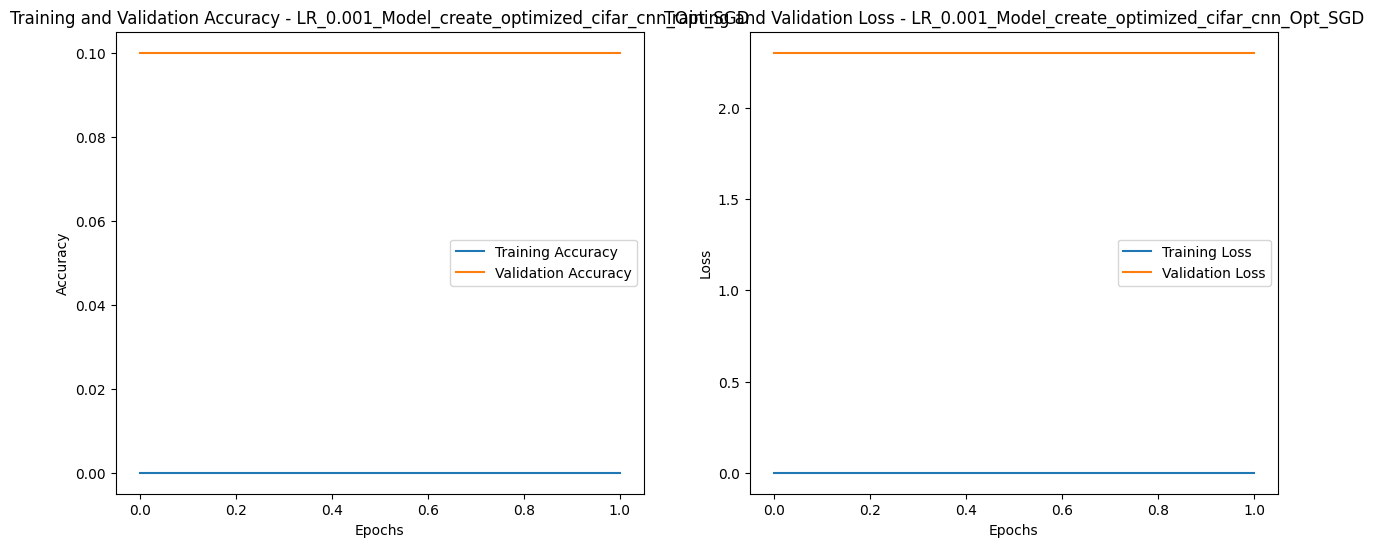

Epoch 1/2
1563/1563 [==============================] - loss: 0.0 - accuracy: 0.0 - val_loss: 2.3113787174224854 - val_accuracy: 0.09969999641180038
Epoch 2/2
157/157 [==============================] - 3s 17ms/step - loss: 2.3114 - accuracy: 0.0997


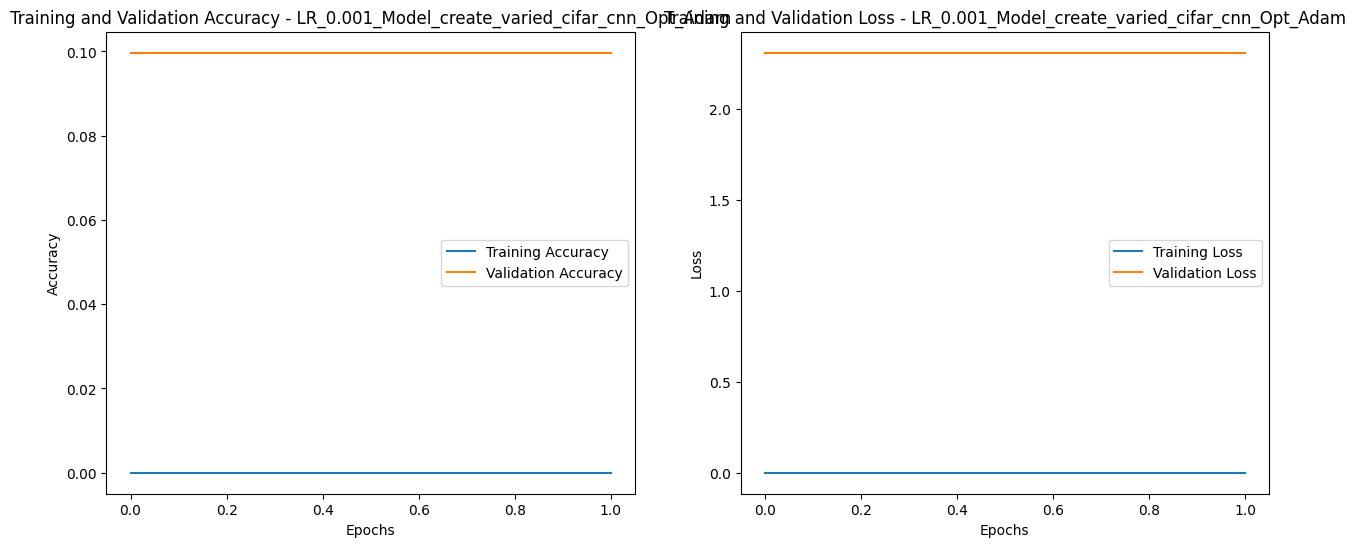

Epoch 1/2
1563/1563 [==============================] - loss: 0.0 - accuracy: 0.0 - val_loss: 2.30495023727417 - val_accuracy: 0.10000000149011612
Epoch 2/2
157/157 [==============================] - 3s 16ms/step - loss: 2.3049 - accuracy: 0.1000


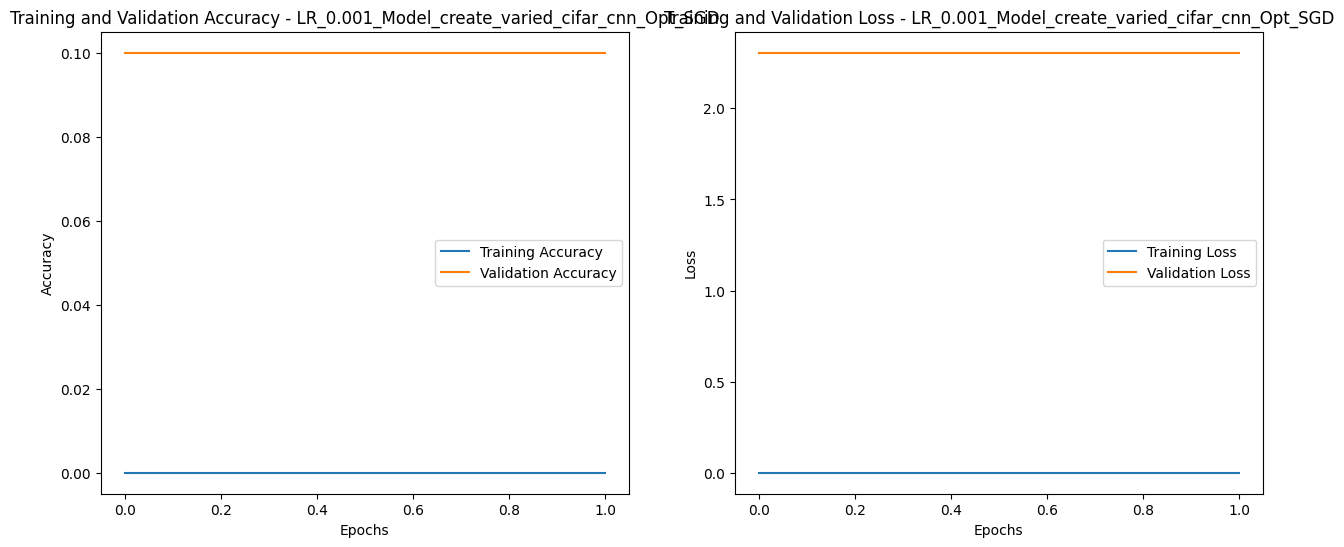

Epoch 1/2
1563/1563 [==============================] - loss: 0.0 - accuracy: 0.0 - val_loss: 2.3048179149627686 - val_accuracy: 0.09600000083446503
Epoch 2/2
157/157 [==============================] - 6s 34ms/step - loss: 2.3049 - accuracy: 0.0960


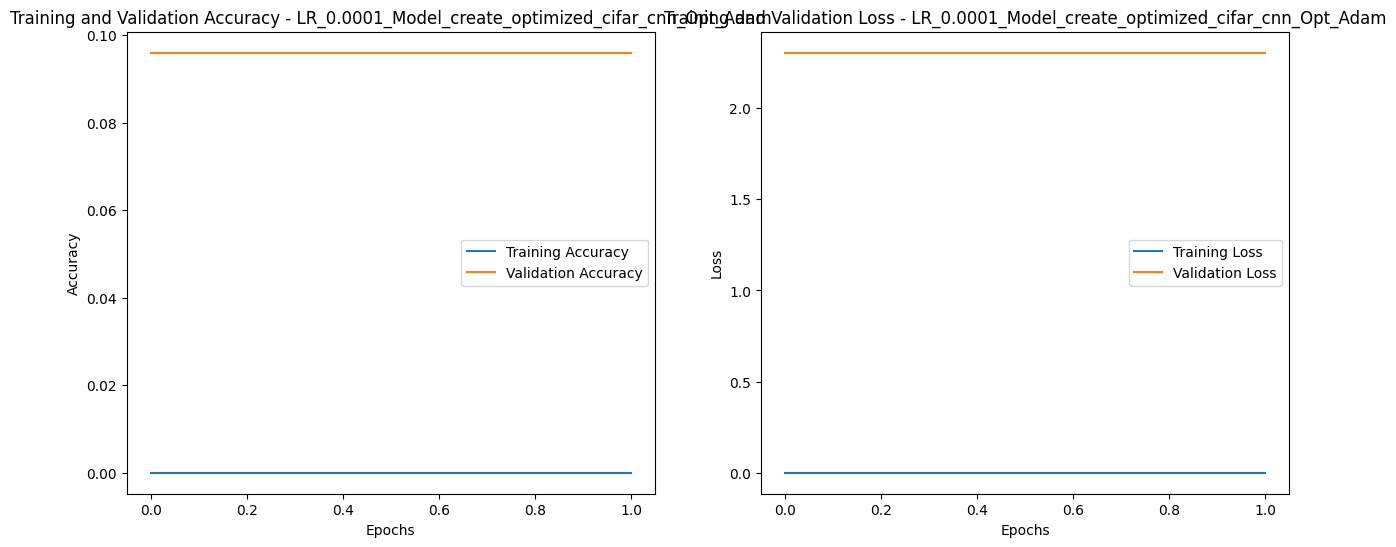

Epoch 1/2
1563/1563 [==============================] - loss: 0.0 - accuracy: 0.0 - val_loss: 2.303854465484619 - val_accuracy: 0.0997999981045723
Epoch 2/2
157/157 [==============================] - 6s 35ms/step - loss: 2.3038 - accuracy: 0.0998


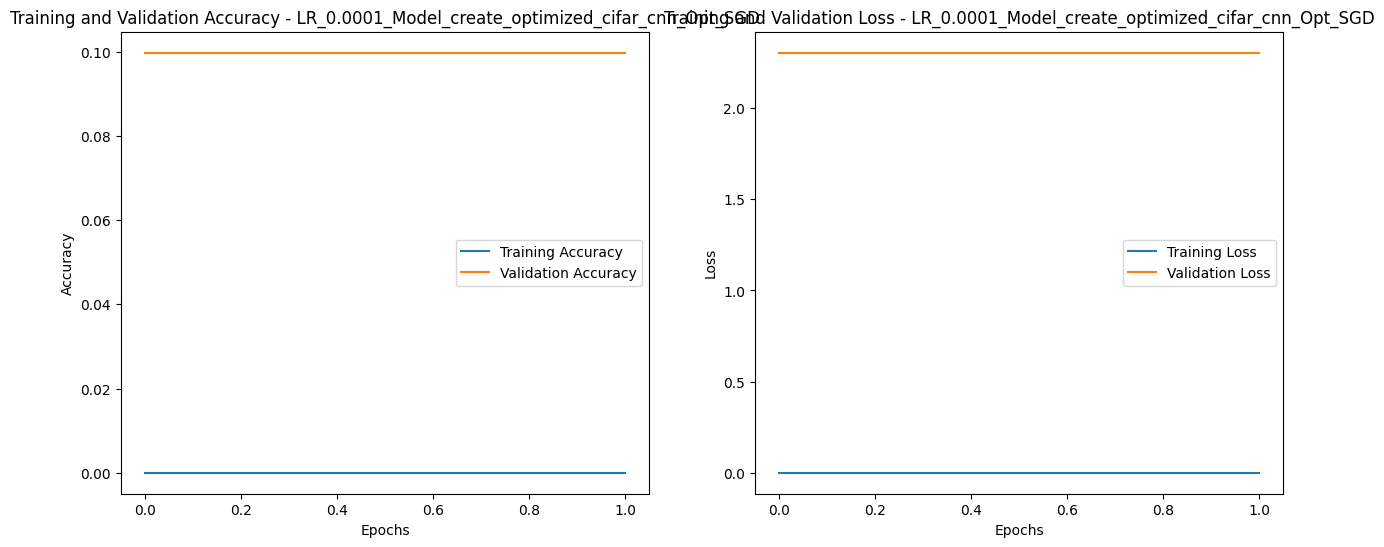

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img / 255.0)  # Normalize between 0 and 1
        return img, label

    train = tfds.load('cifar10', split='train', as_supervised=True)
    test = tfds.load('cifar10', split='test', as_supervised=True)

    train = train.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)

    train = train.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test = test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train, test

def create_optimized_cifar_cnn(name='optimized_cnn', num_filters=[32, 64, 128], kernel_size=3, dense_units=128):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

    model = tf.keras.Model(inputs, x, name=name)
    return model

def create_varied_cifar_cnn(name='varied_cnn', num_filters=[16, 32, 64], kernel_size=3, dense_units=64):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, x, name=name)
    return model


def train_custom_loop(model_fn, optimizer_fn, num_epochs, batch_size, shuffle_buffer_size, lr):
    model = model_fn()
    optimizer = optimizer_fn(lr)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    train_dataset, test_dataset = load_and_prep_cifar(batch_size, shuffle_buffer_size)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        val_loss = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        # Training loop
        # (remains the same)

        train_losses.append(epoch_loss_avg.result().numpy())
        train_accuracies.append(epoch_accuracy.result().numpy())

        # Validation loop
        for x_val, y_val in test_dataset:
            val_predictions = model(x_val, training=False)
            v_loss = loss_fn(y_val, val_predictions)
            val_loss.update_state(v_loss)
            val_accuracy.update_state(y_val, val_predictions)

        val_losses.append(val_loss.result().numpy())
        val_accuracies.append(val_accuracy.result().numpy())

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"1563/1563 [==============================] - loss: {epoch_loss_avg.result()} - accuracy: {epoch_accuracy.result()} - val_loss: {val_loss.result()} - val_accuracy: {val_accuracy.result()}")

    return model, train_losses, train_accuracies, val_losses, val_accuracies


def evaluate(model, test_dataset):
    test_loss, test_accuracy = model.evaluate(test_dataset)
    return test_loss, test_accuracy

def visualize_performance(train_loss, train_accuracy, val_loss, val_accuracy, config_name):
    epochs_range = range(len(train_loss))

    plt.figure(figsize=(15, 6))

    # Plot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {config_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot for loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss - {config_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# Define constants
NUM_EPOCHS = 2
batch_size = 64
shuffle_buffer_size = 10000
learning_rates = [0.001, 0.0001]
model_functions = [create_optimized_cifar_cnn, create_varied_cifar_cnn]
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]

# Load datasets
train_dataset, test_dataset = load_and_prep_cifar(batch_size, shuffle_buffer_size)
for lr in learning_rates:
    for model_fn in model_functions:
        for opt in optimizers:
            model, train_loss, train_accuracy, val_loss, val_accuracy = train_custom_loop(model_fn, opt, NUM_EPOCHS, batch_size, shuffle_buffer_size, lr)
            test_loss, test_accuracy = evaluate(model, test_dataset)
            config_name = f"LR_{lr}_Model_{model_fn.__name__}_Opt_{opt.__name__}"
            visualize_performance(train_loss, train_accuracy, val_loss, val_accuracy, config_name)
